In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
notebook_home = os.path.abspath('')
lookup_results = notebook_home + "/lookup_results"
test_results = notebook_home + "/test_results"
modify_results = notebook_home + "/modify_results"
enron_stat = test_results + "/enron"
github_stat = test_results + "/github"
enron_output = lookup_results + "/enron/output"
enron_input = lookup_results + "/enron/input"
github_input = lookup_results + "/github/input"
github_output = lookup_results + "/github/output"
enron_modify_output = modify_results + "/enron"
github_modify_output = modify_results + "/github"

In [2]:
#Color configuration
import matplotlib.cm as cm
from matplotlib import rcParams
GRAPH_COLOR = cm.YlGnBu
color_dict = {
    "TACO": GRAPH_COLOR(90),
    "NoComp": GRAPH_COLOR(190)
}
# font
rcParams['font.family'] = 'Serif'
legend_size = 15
label_size = 20
tick_size = 20

# Fig size
fig_width=8
fig_height=5

In [3]:
def get_pdf_df(df, column_name, is_log=True):
    ls = [x for x in df[column_name] if x > 10]
    length = len(ls)
    if is_log:
        data = pd.Series(np.log10(ls))
    else:
        data = pd.Series(ls)
    freq = data.value_counts().sort_index(axis=0, ascending=True).reset_index() 
    freq[0] = freq[0] / length
    freq['cumsum'] = np.cumsum(freq[0])
    return freq

In [4]:
def convert_upper_str(num):
    upper_ls = '⁰¹²³⁴⁵⁶⁷⁸⁹'
    index = int(np.log10(num))
    return str(10) + upper_ls[int(np.log10(num))]

In [5]:
def plot_percentile(df_ls, 
                    legend_ls, 
                    xlabel, 
                    ylabel, 
                    x_tick_min,
                    x_tick_max,
                    x_tick_num,
                    fig_size=(fig_width, fig_height),
                    legend_size=legend_size,
                    tick_size=tick_size,
                    label_size=label_size,
                    color_dict=color_dict,
                    save_path=None):
    assert len(df_ls) == len(legend_ls)
    fig, ax = plt.subplots(figsize=fig_size)
    for i in range(len(df_ls)):
        df, label = df_ls[i], legend_ls[i]
        ax.plot(df['index'], df['cumsum'], label=label, color=color_dict[label])
    
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    x_ticks = np.arange(x_tick_min, x_tick_max+0.1, step=(x_tick_max - x_tick_min)/x_tick_num).astype(int)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([convert_upper_str(10**x) for x in x_ticks], fontsize=tick_size)
    ax.legend(fontsize=legend_size)
    fig.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# 1. Compressed Formula Graph Sizes

In [6]:
def graph_compare_preprocess(df, is_inrow=False):
    df['Edges_Diff'] = df['numEdges'] - df['numCompEdges']
    df['Edges_Prec'] = df['numCompEdges'] / df['numEdges']
    if not is_inrow:
        pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain', 'RRGap']
        for pattern in pattern_type:
            if pattern != 'RRGap':
                df[pattern + "_Diff"] = df[pattern + "_NoComp"] - df[pattern + "_Comp"]
            else:
                df[pattern + "_Diff"] = 0
                gaps = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven']
                for gap in gaps:
                    pattern_name = pattern + gap
                    df[pattern + "_Diff"] += (df[pattern_name + "_NoComp"] - df[pattern_name + "_Comp"])
    return df

In [7]:
df_enron_stat = graph_compare_preprocess(pd.read_csv(enron_stat + "/" + "enron_taco_stat_10k.csv"))
df_github_stat = graph_compare_preprocess(pd.read_csv(github_stat + "/" + "github_taco_stat_10k.csv"))
df_enron_inrow_stat = graph_compare_preprocess(pd.read_csv(enron_stat + "/" + "enron_inrow_taco_stat_10k.csv"), True)
df_github_inrow_stat = graph_compare_preprocess(pd.read_csv(github_stat + "/" + "github_inrow_taco_stat_10k.csv"), True)

In [8]:
df_enron_stat.head()

,fileName,numFormulae,numVertices,numEdges,numCompVertices,numCompEdges,RR-Chain_Comp,RR-Chain_NoComp,RR_Comp,RR_NoComp,...,NoComp_Comp,NoComp_NoComp,Edges_Diff,Edges_Prec,RR_Diff,RF_Diff,FR_Diff,FF_Diff,RR-Chain_Diff,RRGap_Diff
0,chris_germany_000_1_2.pst.1111.xls,8270,27200,26350,11520,11160,0,0,10230,24180,...,0,0,15190,0.423529,13950,0,0,0,0,1240
1,chris_germany_000_1_2.pst.1136.xls,1707,54464,52762,23059,22322,0,0,20446,48393,...,3,3,30440,0.423070,27947,0,0,0,0,2493
2,kevin_ruscitti_000_1_1.pst.100.xls,8268,27200,26350,11520,11160,0,0,10230,24180,...,0,0,15190,0.423529,13950,0,0,0,0,1240
3,kevin_ruscitti_000_1_1.pst.101.xls,8268,27200,26350,11520,11160,0,0,10230,24180,...,0,0,15190,0.423529,13950,0,0,0,0,1240
4,kevin_ruscitti_000_1_1.pst.152.xls,12398,27200,26350,11520,11160,0,0,10230,24180,...,0,0,15190,0.423529,13950,0,0,0,0,1240


## 1.1 Formula graph sizes after TACO compression (low is better)

In [9]:
df_graph_enron_compare = pd.DataFrame()
df_graph_enron_compare.index = ['NoComp', 'TACO-Inrow', 'TACO']
df_graph_enron_compare['Vertices'] = [df_enron_stat['numVertices'].sum(), df_enron_inrow_stat['numCompVertices'].sum(), df_enron_stat['numCompVertices'].sum()]
df_graph_enron_compare['Edges'] = [df_enron_stat['numEdges'].sum(), df_enron_inrow_stat['numCompEdges'].sum(), df_enron_stat['numCompEdges'].sum()]
df_graph_enron_compare['Vertices_Percentage'] = df_graph_enron_compare['Vertices'] / df_graph_enron_compare['Vertices'].max()
df_graph_enron_compare['Edges_Percentage'] = df_graph_enron_compare['Edges'] / df_graph_enron_compare['Edges'].max()
df_graph_enron_compare

,Vertices,Edges,Vertices_Percentage,Edges_Percentage
NoComp,18467065,27083750,1.000000,1.000000
TACO-Inrow,7501502,14077044,0.406210,0.519760
TACO,1315183,1210209,0.071218,0.044684


In [10]:
df_graph_github_compare = pd.DataFrame()
df_graph_github_compare.index = ['NoComp', 'TACO-Inrow', 'TACO']
df_graph_github_compare['Vertices'] = [df_github_stat['numVertices'].sum(), df_github_inrow_stat['numCompVertices'].sum(), df_github_stat['numCompVertices'].sum()]
df_graph_github_compare['Edges'] = [df_github_stat['numEdges'].sum(), df_github_inrow_stat['numCompVertices'].sum(), df_github_stat['numCompEdges'].sum()]
df_graph_github_compare['Vertices_Percentage'] = df_graph_github_compare['Vertices'] / df_graph_github_compare['Vertices'].max()
df_graph_github_compare['Edges_Percentage'] = df_graph_github_compare['Edges'] / df_graph_github_compare['Edges'].max()
df_graph_github_compare

,Vertices,Edges,Vertices_Percentage,Edges_Percentage
NoComp,160240056,216050038,1.000000,1.000000
TACO-Inrow,45453962,45453962,0.283662,0.210386
TACO,3524109,2884193,0.021993,0.013350


## 1.2 The number of edges reduced by TACO (high is better)

In [11]:
df_enron_edge_reduce = pd.DataFrame()
df_enron_edge_reduce['TACO-Inrow'] = df_enron_inrow_stat['Edges_Diff']
df_enron_edge_reduce['TACO'] = df_enron_stat['Edges_Diff']
df_enron_edge_reduce.describe().T[['max', '75%', '50%', 'mean']]

,max,75%,50%,mean
TACO-Inrow,383012.0,22108.0,15003.0,21933.736931
TACO,573599.0,43203.0,20417.0,43631.603710


In [12]:
df_github_edge_reduce = pd.DataFrame()
df_github_edge_reduce['TACO-Inrow'] = df_github_inrow_stat['Edges_Diff']
df_github_edge_reduce['TACO'] = df_github_stat['Edges_Diff']
df_github_edge_reduce.describe().T[['max', '75%', '50%', 'mean']]

,max,75%,50%,mean
TACO-Inrow,2193476.0,53279.5,22758.0,58334.711002
TACO,2455807.0,91166.5,42150.0,105404.228243


## 1.3 Remaining edge fractions after compression (low is better)

In [13]:
df_enron_edge_prec = pd.DataFrame()
df_enron_edge_prec['TACO-Inrow'] = df_enron_inrow_stat['Edges_Prec']
df_enron_edge_prec['TACO'] = df_enron_stat['Edges_Prec']
df_enron_edge_prec.describe().T[['min', '25%', '50%', 'mean']]

,min,25%,50%,mean
TACO-Inrow,0.00001,0.050397,0.377372,0.420695
TACO,0.00001,0.003395,0.013835,0.069730


In [14]:
df_github_edge_prec = pd.DataFrame()
df_github_edge_prec['TACO-Inrow'] = df_github_inrow_stat['Edges_Prec']
df_github_edge_prec['TACO'] = df_github_stat['Edges_Prec']
df_github_edge_prec.describe().T[['min', '25%', '50%', 'mean']]

,min,25%,50%,mean
TACO-Inrow,0.000005,0.000911,0.135342,0.358910
TACO,0.000002,0.000388,0.002020,0.025021


## 1.4 Number of edges reduced by each pattern (high is better)

In [15]:
df_enron_pattern_reduce = pd.DataFrame()
pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain', 'RRGap']
for pattern in pattern_type:
    df_enron_pattern_reduce[pattern] = df_enron_stat[pattern + "_Diff"]
df_enron_pattern_stat = pd.DataFrame()
df_enron_pattern_stat.index = df_enron_pattern_reduce.T.index
df_enron_pattern_stat['Sum'] = df_enron_pattern_reduce.sum()
df_enron_pattern_stat['Max'] = df_enron_pattern_reduce.max()
df_enron_pattern_stat

,Sum,Max
RR,16316157,258333
RF,1879,1413
FR,149775,13815
FF,3657207,170510
RR-Chain,450504,24596
RRGap,689711,48670


In [16]:
df_github_pattern_reduce = pd.DataFrame()
pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain', 'RRGap']
for pattern in pattern_type:
    df_github_pattern_reduce[pattern] = df_github_stat[pattern + "_Diff"]
df_github_pattern_stat = pd.DataFrame()
df_github_pattern_stat.index = df_github_pattern_reduce.T.index
df_github_pattern_stat['Sum'] = df_github_pattern_reduce.sum()
df_github_pattern_stat['Max'] = df_github_pattern_reduce.max()
df_github_pattern_stat

,Sum,Max
RR,135900672,1754081
RF,13357,9999
FR,178259,39008
FF,22244085,736581
RR-Chain,5777668,399996
RRGap,1424659,572425


# 2. Building Graphs

In [17]:
column_list = ['fileName', 'GraphBuildTime']
df_enron_taco_max = pd.read_csv(f"{enron_output}/enron_max_taco_10k.csv")[column_list]
df_enron_taco_long = pd.read_csv(f"{enron_output}/enron_long_taco_10k.csv")[column_list]
df_enron_nocomp_max = pd.read_csv(f"{enron_output}/enron_max_nocomp_10k.csv")[column_list]
df_enron_nocomp_long = pd.read_csv(f"{enron_output}/enron_long_nocomp_10k.csv")[column_list]
df_github_taco_max =  pd.read_csv(f"{github_output}/github_max_taco_10k.csv")[column_list]
df_github_taco_long = pd.read_csv(f"{github_output}/github_long_taco_10k.csv")[column_list]
df_github_nocomp_max = pd.read_csv(f"{github_output}/github_max_nocomp_10k.csv")[column_list]
df_github_nocomp_long = pd.read_csv(f"{github_output}/github_long_nocomp_10k.csv")[column_list]

In [18]:
df_enron_taco = pd.merge(df_enron_taco_max, df_enron_taco_long, how="inner", on=["fileName"])
df_enron_nocomp = pd.merge(df_enron_nocomp_max, df_enron_nocomp_long, how="inner", on=["fileName"])
df_enron_taco['TACO_GraphBuildTime'] = (df_enron_taco['GraphBuildTime_x'] + df_enron_taco['GraphBuildTime_y']) / 2.
df_enron_nocomp['NoComp_GraphBuildTime'] = (df_enron_nocomp['GraphBuildTime_x'] + df_enron_nocomp['GraphBuildTime_y']) / 2.

In [19]:
enron_graph_result = pd.merge(df_enron_taco, df_enron_nocomp, how="inner", on=['fileName'])[['fileName', 'TACO_GraphBuildTime', 'NoComp_GraphBuildTime']]

In [20]:
enron_graph_result.head()

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
0,stacey_white_000_1_1.pst.254.xls,1681.0,1078.0
1,darron_c_giron_002_1_1_1.pst.177.xls,864.5,261.5
2,stacey_white_000_1_1.pst.262.xls,2751.5,1505.0
3,mike_grigsby_000_1_1_1.pst.248.xls,128.0,131.5
4,kevin_ruscitti_000_1_1.pst.156.xls,4269.0,170.5


In [21]:
enron_graph_result['TACO_GraphBuildTime'].mean(), enron_graph_result['NoComp_GraphBuildTime'].mean()

(1011.316722972973, 322.6418918918919)

In [22]:
enron_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
503,jim_schwieger_000_1_1.pst.111.xls,9413.5,931.0
579,chris_germany_000_1_2.pst.1136.xls,7691.0,367.0
572,jim_schwieger_000_1_1.pst.112.xls,7387.5,315.5
486,mary_fischer_000_1_1.pst.116.xls,6574.5,145.0
34,jim_schwieger_000_1_1.pst.113.xls,6253.0,335.5
...,...,...,...
387,john_arnold_000_1_2.pst.135.xls,61.5,65.5
516,vkaminski_000_1_1_1.pst.182.xls,60.0,78.0
131,richard_shapiro_001_1_2.pst.124.xls,56.0,67.0
334,joe_quenet_000_1_1.pst.17.xls,49.0,70.0


In [23]:
enron_graph_result[enron_graph_result["NoComp_GraphBuildTime"] - enron_graph_result["TACO_GraphBuildTime"] > 500]

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
12,phillip_allen_000_1_1.pst.212.xls,1991.0,2591.0


In [24]:
freq_enron_taco = get_pdf_df(enron_graph_result, 'TACO_GraphBuildTime')
freq_enron_nocomp = get_pdf_df(enron_graph_result, 'NoComp_GraphBuildTime')

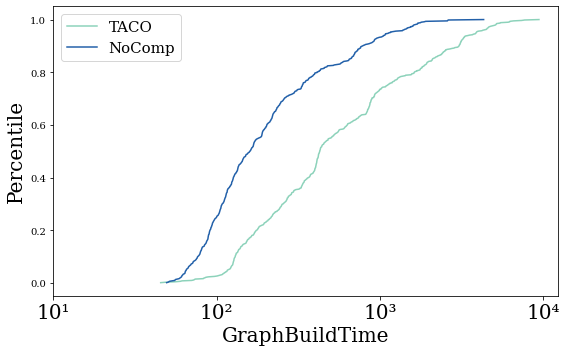

In [25]:
plot_percentile([freq_enron_taco, freq_enron_nocomp], 
                ["TACO", "NoComp"],
                xlabel="GraphBuildTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3
               )

In [26]:
df_github_taco = pd.merge(df_github_taco_max, df_github_taco_long, how="inner", on=["fileName"])
df_github_nocomp = pd.merge(df_github_nocomp_max, df_github_nocomp_long, how="inner", on=["fileName"])
df_github_taco['TACO_GraphBuildTime'] = (df_github_taco['GraphBuildTime_x'] + df_github_taco['GraphBuildTime_y']) / 2.
df_github_nocomp['NoComp_GraphBuildTime'] = (df_github_nocomp['GraphBuildTime_x'] + df_github_nocomp['GraphBuildTime_y']) / 2.

In [27]:
github_graph_result = pd.merge(df_github_taco, df_github_nocomp, how="inner", on=['fileName'])[['fileName', 'TACO_GraphBuildTime', 'NoComp_GraphBuildTime']]

In [28]:
github_graph_result[github_graph_result["NoComp_GraphBuildTime"] - github_graph_result["TACO_GraphBuildTime"] > 5000]

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
758,PendaHealthdata__Analysis.xlsx,12475.5,21280.0
2168,trace_ros2_10.xlsx,5597.0,13851.5


In [29]:
github_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
994,teeeest.xlsx,163226.5,7715.5
308,Gastos.xlsx,88683.5,1403.0
638,2015하수도통계(최종).xlsx,38741.0,5720.0
2031,correc_precorte_13-05_000.xlsx,37999.5,3111.0
1367,zasco_baseline.xlsx,34331.0,8590.5
...,...,...,...
1509,Wykresy.xlsx,50.5,87.5
242,All London 2012 athletes.xlsx,48.5,103.5
1774,Test_Data_label.xlsx,48.5,64.0
1746,VnEmoLex.xlsx,47.5,112.5


In [30]:
github_graph_result['TACO_GraphBuildTime'].mean(), github_graph_result['NoComp_GraphBuildTime'].mean()

(1480.2192743764172, 745.8630385487528)

In [31]:
freq_github_taco = get_pdf_df(github_graph_result, 'TACO_GraphBuildTime')
freq_github_nocomp = get_pdf_df(github_graph_result, 'NoComp_GraphBuildTime')

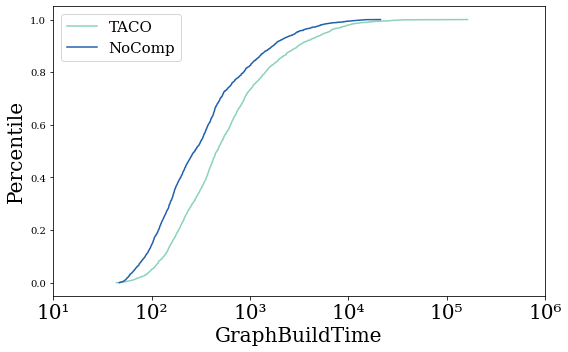

In [32]:
plot_percentile([freq_github_taco, freq_github_nocomp], 
                ["TACO", "NoComp"],
                xlabel="GraphBuildTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=6,
                x_tick_num=5
               )

# 3. Returning Control to Users

In [33]:
def rename_columns(df, is_long=False):
    rename_map = {
        "TACOLookupSize": "taco_size",
        "TACOLookupTime": "taco_time",
        "TACOPostProcessedLookupSize": "taco_post_size",
        "TACOPostProcessedLookupTime": "taco_post_time",
        "NoCompLookupSize": "nocomp_size",
        "NoCompLookupTime": "nocomp_time",
        "NoCompPostProcessedLookupSize": "nocomp_post_size",
        "NoCompPostProcessedLookupTime": "nocomp_post_time",
    }
    
    if is_long:
        for key in rename_map:
            rename_map[key] = "long_" + rename_map[key]
    else:
        for key in rename_map:
            rename_map[key] = "max_" + rename_map[key]
            
    df = df.rename(columns=rename_map)
    if "GraphBuildTime" in list(df.columns):
        df = df.drop(['GraphBuildTime'], axis=1)
    
    remain_cols = [x for x in list(df.columns) if "post" not in x]
    return df[remain_cols]

In [34]:
def read_and_average_files(dir_path, fileName, is_long=False):
    df = rename_columns(pd.read_csv(dir_path + "/" + fileName + ".csv"), is_long)
    df2 = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_2.csv"), is_long)
    df3 = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_3.csv"), is_long)
    column_list = list(df.columns)
    df_merged = pd.merge(df, df2, how="inner", on=[column_list[0], column_list[1]])
    df_merged = pd.merge(df_merged, df3, how="inner", on=[column_list[0], column_list[1]])
    list1, list2 = [], []
    for i in range(len(df_merged)):
        ls = [df_merged.loc[i, col_name] for col_name in list(df_merged.columns) if column_list[2] in col_name]
        ls2 = [df_merged.loc[i, col_name] for col_name in list(df_merged.columns) if column_list[3] in col_name]
        list1.append(np.mean(ls))
        list2.append(np.mean(ls2))
    df_merged[column_list[2]] = list1
    df_merged[column_list[3]] = list2
    return df_merged[column_list]

In [35]:
df_enron_taco_max = read_and_average_files(enron_output, "enron_max_taco_10k", False)
df_enron_taco_long = read_and_average_files(enron_output, "enron_long_taco_10k", True)
df_enron_nocomp_max = read_and_average_files(enron_output, "enron_max_nocomp_10k", False)
df_enron_nocomp_long = read_and_average_files(enron_output, "enron_long_nocomp_10k", True)
df_github_taco_max = read_and_average_files(github_output, "github_max_taco_10k", False)
df_github_taco_long = read_and_average_files(github_output, "github_long_taco_10k", True)
df_github_nocomp_max = read_and_average_files(github_output, "github_max_nocomp_10k", False)
df_github_nocomp_long = read_and_average_files(github_output, "github_long_nocomp_10k", True)

In [36]:
df_github_nocomp_long.head()

,fileName,Longest Dep Ref,long_nocomp_size,long_nocomp_time
0,1. Excel Homework.xlsx,Sheet1:J3248,1.0,32.0
1,2019-05-23-0936_empty_racir.xlsx,Measurements:C11,5610.0,318.0
2,NIRISS_SIAF.xlsx,DDC:C20,22.0,0.0
3,工作簿1-20181122170204822.xlsx,不良明细:CEA5,2.0,0.0
4,W22704-181.xlsx,Sheet1:D2,14196.0,151.0


In [37]:
df_enron_max = pd.merge(df_enron_taco_max, df_enron_nocomp_max, how="inner", on=["fileName", "Max Dep Ref"])
df_enron_long = pd.merge(df_enron_taco_long, df_enron_nocomp_long, how="inner", on=["fileName", "Longest Dep Ref"])

In [38]:
df_enron_merged = pd.merge(df_enron_max, df_enron_long, how="inner", on=["fileName"])
# df_enron_merged.to_csv("./enron_result_merged.csv", index=False)

In [39]:
df_enron_merged.head()

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time,Longest Dep Ref,long_taco_size,long_taco_time,long_nocomp_size,long_nocomp_time
0,stacey_white_000_1_1.pst.254.xls,AlphaSort:F6836,3.0,9.333333,3.0,29.0,AlphaSort:F4400,3.0,16.000000,3.0,30.000000
1,darron_c_giron_002_1_1_1.pst.177.xls,Darron:E5,205.0,8.333333,2978.0,78.0,Darron:J4,205.0,6.000000,2978.0,90.000000
2,stacey_white_000_1_1.pst.262.xls,BRA Power:A6,28.0,0.666667,4385.0,463.0,BRA Power:A6,28.0,0.666667,4385.0,495.333333
3,mike_grigsby_000_1_1_1.pst.248.xls,Months:F4,4.0,0.000000,306.0,3.0,Months:F4,4.0,0.333333,306.0,2.000000
4,kevin_ruscitti_000_1_1.pst.156.xls,03-21-00AM:BT499,0.0,0.000000,0.0,0.0,03-21-00AM:X531,1.0,0.000000,1.0,0.000000


In [40]:
df_github_max = pd.merge(df_github_taco_max, df_github_nocomp_max, how="inner", on=["fileName", "Max Dep Ref"])
df_github_long = pd.merge(df_github_taco_long, df_github_nocomp_long, how="inner", on=["fileName", "Longest Dep Ref"])

In [41]:
df_github_merged = pd.merge(df_github_max, df_github_long, how="inner", on=["fileName"])
# df_github_merged.to_csv("./github_result_merged.csv", index=False)

In [42]:
df_github_merged.head()

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time,Longest Dep Ref,long_taco_size,long_taco_time,long_nocomp_size,long_nocomp_time
0,1. Excel Homework.xlsx,Sheet1:E4030,2.0,8.666667,2.0,28.333333,Sheet1:J3248,1.0,9.000000,1.0,32.0
1,2019-05-23-0936_empty_racir.xlsx,Measurements:E13,20.0,1.333333,6600.0,238.000000,Measurements:C11,17.0,1.000000,5610.0,318.0
2,NIRISS_SIAF.xlsx,Calc:AE3,23.0,0.333333,690.0,17.333333,DDC:C20,6.0,0.333333,22.0,0.0
3,工作簿1-20181122170204822.xlsx,不良明细:CBJ5,1.0,0.000000,2.0,0.333333,不良明细:CEA5,1.0,0.333333,2.0,0.0
4,W22704-181.xlsx,Sheet1:E2,4.0,0.000000,14196.0,172.000000,Sheet1:D2,4.0,0.333333,14196.0,151.0


In [76]:
df_enron_max.sort_values(by="max_nocomp_time", ascending=False)

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time
267,harry_arora_000_1_1.pst.130.xls,WorkingData:E3,5.0,0.000000,4613.0,10214.0
87,dutch_quigley_000_1_1.pst.51.xls,Sheet1:A1536,5.0,0.000000,4808.0,10006.0
563,jim_schwieger_000_1_1.pst.71.xls,NYMEX-PR:A1536,5.0,0.000000,4909.0,9953.0
375,jim_schwieger_000_1_1.pst.100.xls,NYMEX-PR:A1536,5.0,0.000000,4909.0,9640.0
585,jim_schwieger_000_1_1.pst.106.xls,NYMEX-PR:A1536,5.0,0.000000,4909.0,9249.0
...,...,...,...,...,...,...
436,stacey_white_000_1_1.pst.249.xls,OP.Power Desk Daily Price:B7,3.0,0.000000,61.0,0.0
437,larry_may_000_1_1.pst.312.xls,DATA:B3,1.0,0.000000,60.0,0.0
438,vkaminski_000_1_1_1.pst.258.xls,R11_logs:BM389,0.0,0.000000,0.0,0.0
207,don_baughman_000_1_1.pst.145.xls,Sheet1:C20,37.0,0.000000,37.0,0.0


In [77]:
df_github_max.sort_values(by="max_nocomp_time", ascending=False)

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time
152,gaslines_model_public.xlsx,Transect:A9,263.0,5.000000,69509.0,788242.000000
1729,Graphic_diagnostic.xlsx,Summary:B9994,4.0,0.000000,20002.0,175595.333333
371,分解法乘法 C.xlsx,分解法:R41,19.0,0.333333,35050.0,79014.666667
1306,葛林布雷選股.xlsx,葛林布雷20161023:C591,21.0,0.333333,28659.0,67260.666667
1292,Budget_Plan_Project_20180803-form.xlsx,TAB_List:P5,2.0,0.000000,5997.0,52241.333333
...,...,...,...,...,...,...
1279,compare-opt-noopt.xlsx,all_stats_noopt:G3165,2.0,0.000000,2.0,0.000000
439,Objectlist2.xlsx,Tabelle4:E22,2.0,0.000000,2.0,0.000000
1275,Speed test (UK only) 3 speed fields.xlsx,Speed test (UK only) 3 speed fi:C48213,3.0,0.000000,3.0,0.000000
440,compareFixedCNY.xlsx,Sheet1:B3005,1.0,0.000000,1.0,0.000000


### CDF Plot

In [44]:
freq_enron_max_taco_size = get_pdf_df(df_enron_merged, 'max_taco_size', True)
freq_enron_max_nocomp_size = get_pdf_df(df_enron_merged, 'max_nocomp_size', True)
freq_enron_max_taco_time = get_pdf_df(df_enron_merged, 'max_taco_time', True)
freq_enron_max_nocomp_time = get_pdf_df(df_enron_merged, 'max_nocomp_time', True)
freq_enron_long_taco_size = get_pdf_df(df_enron_merged, 'long_taco_size', True)
freq_enron_long_nocomp_size = get_pdf_df(df_enron_merged, 'long_nocomp_size', True)
freq_enron_long_taco_time = get_pdf_df(df_enron_merged, 'long_taco_time', True)
freq_enron_long_nocomp_time = get_pdf_df(df_enron_merged, 'long_nocomp_time', True)

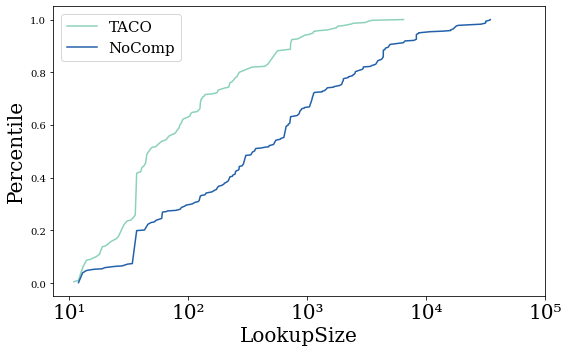

In [45]:
plot_percentile([freq_enron_max_taco_size, freq_enron_max_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

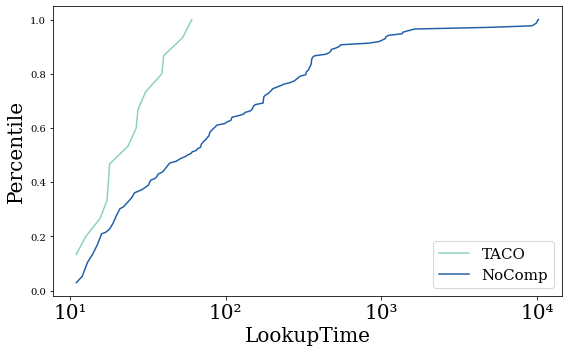

In [46]:
plot_percentile([freq_enron_max_taco_time, freq_enron_max_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3
               )

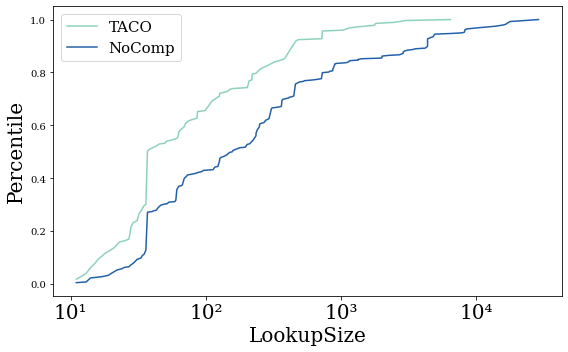

In [47]:
plot_percentile([freq_enron_long_taco_size, freq_enron_long_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3
               )

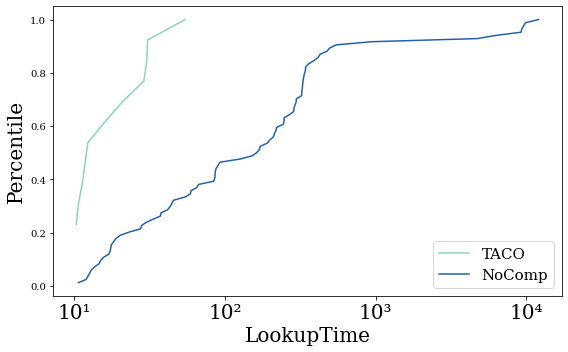

In [48]:
plot_percentile([freq_enron_long_taco_time, freq_enron_long_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3
               )

In [49]:
freq_github_max_taco_size = get_pdf_df(df_github_merged, 'max_taco_size', True)
freq_github_max_nocomp_size = get_pdf_df(df_github_merged, 'max_nocomp_size', True)
freq_github_max_taco_time = get_pdf_df(df_github_merged, 'max_taco_time', True)
freq_github_max_nocomp_time = get_pdf_df(df_github_merged, 'max_nocomp_time', True)
freq_github_long_taco_size = get_pdf_df(df_github_merged, 'long_taco_size', True)
freq_github_long_nocomp_size = get_pdf_df(df_github_merged, 'long_nocomp_size', True)
freq_github_long_taco_time = get_pdf_df(df_github_merged, 'long_taco_time', True)
freq_github_long_nocomp_time = get_pdf_df(df_github_merged, 'long_nocomp_time', True)

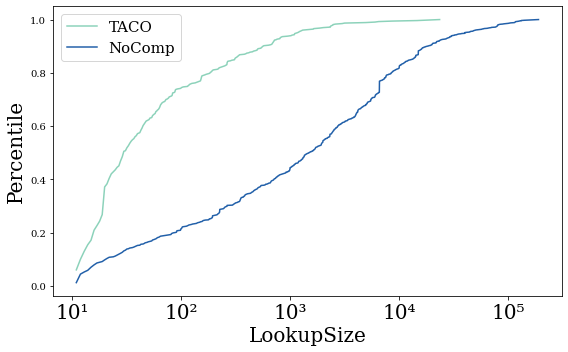

In [50]:
plot_percentile([freq_github_max_taco_size, freq_github_max_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

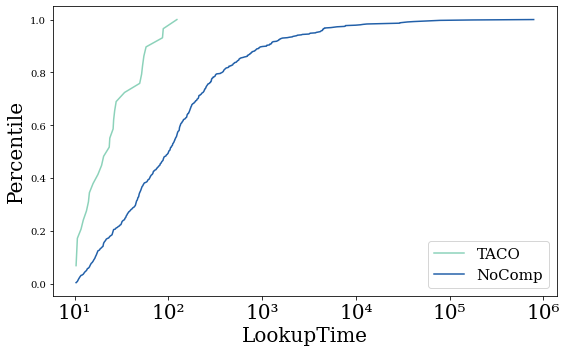

In [51]:
plot_percentile([freq_github_max_taco_time, freq_github_max_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=6,
                x_tick_num=5
               )

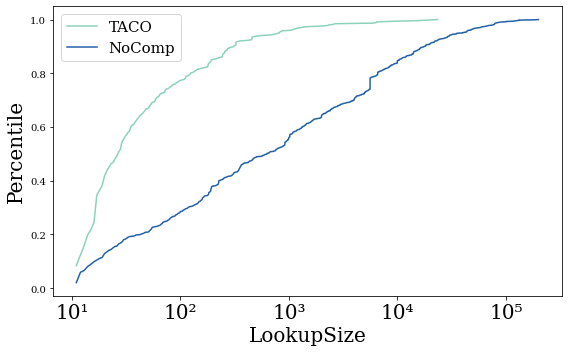

In [52]:
plot_percentile([freq_github_long_taco_size, freq_github_long_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

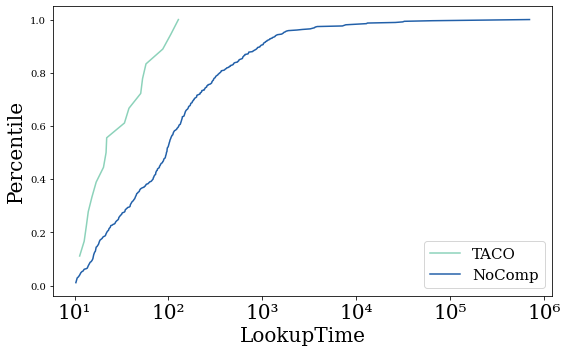

In [53]:
plot_percentile([freq_github_long_taco_time, freq_github_long_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=6,
                x_tick_num=5
               )

### Analyze Enron results

In [54]:
df_enron_merged

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time,Longest Dep Ref,long_taco_size,long_taco_time,long_nocomp_size,long_nocomp_time
0,stacey_white_000_1_1.pst.254.xls,AlphaSort:F6836,3.0,9.333333,3.0,29.0,AlphaSort:F4400,3.0,16.000000,3.0,30.000000
1,darron_c_giron_002_1_1_1.pst.177.xls,Darron:E5,205.0,8.333333,2978.0,78.0,Darron:J4,205.0,6.000000,2978.0,90.000000
2,stacey_white_000_1_1.pst.262.xls,BRA Power:A6,28.0,0.666667,4385.0,463.0,BRA Power:A6,28.0,0.666667,4385.0,495.333333
3,mike_grigsby_000_1_1_1.pst.248.xls,Months:F4,4.0,0.000000,306.0,3.0,Months:F4,4.0,0.333333,306.0,2.000000
4,kevin_ruscitti_000_1_1.pst.156.xls,03-21-00AM:BT499,0.0,0.000000,0.0,0.0,03-21-00AM:X531,1.0,0.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
587,don_baughman_000_1_1.pst.127.xls,Sheet1:C47,37.0,0.333333,37.0,0.0,Sheet1:C38,37.0,0.333333,37.0,0.000000
588,kevin_ruscitti_000_1_1.pst.4.xls,Swap:A8,29.0,0.333333,1159.0,13.0,Swap:A8,29.0,0.000000,1159.0,17.000000
589,jane_tholt_000_1_1.pst.198.xls,Summary:B185,57.0,0.333333,1485.0,121.0,Study 4a:A9,12.0,0.333333,82.0,0.666667
590,andy_zipper_000_1_1.pst.67.xls,DD-ENA:F500,4.0,0.000000,8.0,0.0,DD-EGL:P29,3.0,0.000000,3.0,0.000000


In [55]:
df_larger_than = df_enron_merged[(df_enron_merged["max_taco_time"] > df_enron_merged["max_nocomp_time"]) & (df_enron_merged["max_nocomp_time"] > 10)]
df_larger_than[["fileName", "max_taco_time", "max_nocomp_time"]]

,fileName,max_taco_time,max_nocomp_time
19,kevin_ruscitti_000_1_1.pst.125.xls,53.0,52.0


In [56]:
threshold=500
df_enron_merged[df_enron_merged["max_nocomp_time"] > threshold][["fileName", "max_nocomp_time"]]

,fileName,max_nocomp_time
87,dutch_quigley_000_1_1.pst.51.xls,10006.0
127,mike_grigsby_000_1_1_1.pst.106.xls,1116.0
144,matthew_lenhart_000_1_1.pst.23.xls,1639.0
173,stacey_white_000_1_1.pst.287.xls,513.0
197,matthew_lenhart_000_1_1.pst.20.xls,1498.0
220,mark_haedicke_000_1_2.pst.31.xls,966.0
267,harry_arora_000_1_1.pst.130.xls,10214.0
269,matthew_lenhart_000_1_1.pst.1.xls,538.0
280,vkaminski_001_1_2_1.pst.62.xls,550.0
301,mike_grigsby_000_1_1_1.pst.108.xls,1378.0


In [57]:
df_enron_merged[df_enron_merged["long_nocomp_time"] > threshold][["fileName", "long_nocomp_time"]]

,fileName,long_nocomp_time
87,dutch_quigley_000_1_1.pst.51.xls,9307.666667
220,mark_haedicke_000_1_2.pst.31.xls,934.333333
267,harry_arora_000_1_1.pst.130.xls,12022.333333
280,vkaminski_001_1_2_1.pst.62.xls,546.666667
375,jim_schwieger_000_1_1.pst.100.xls,9857.333333
526,john_griffith_000_1_1.pst.185.xls,6268.000000
563,jim_schwieger_000_1_1.pst.71.xls,9573.666667
576,kevin_presto_000_1_1.pst.16.xls,4728.666667
585,jim_schwieger_000_1_1.pst.106.xls,9209.000000


In [58]:
df_enron_merged[df_enron_merged["max_taco_time"] > threshold][["fileName", "max_taco_time"]]

,fileName,max_taco_time


In [59]:
df_enron_merged[df_enron_merged["long_taco_time"] > threshold][["fileName", "long_taco_time"]]

,fileName,long_taco_time


### Analyze github dataset

In [60]:
df_larger_than = df_github_merged[(df_github_merged["max_taco_time"] > df_github_merged["max_nocomp_time"]) & (df_github_merged["max_nocomp_time"] > 10)]
df_larger_than[["fileName", "max_taco_time", "max_nocomp_time"]]

,fileName,max_taco_time,max_nocomp_time


In [61]:
threshold=500
df_github_merged[df_github_merged["max_nocomp_time"] > threshold][["fileName", "max_nocomp_time"]]

,fileName,max_nocomp_time
10,Fact2Sheet_Corona_20200607.xlsx,4483.666667
65,Kraken_BTCEUR_1h.xlsx,549.666667
90,crime_v3.xlsx,714.333333
152,gaslines_model_public.xlsx,788242.000000
154,Tio Cash Master 1400 Find Ratio of Star-fam.xlsx,579.000000
...,...,...
2151,经济总表.xlsx,41303.333333
2166,최경묵_퍼셉트론엑셀.xlsx,1304.333333
2196,aero_test.xlsx,1255.333333
2199,Ventas 2.0 exceldiario.xlsx,2094.333333


In [62]:
df_github_merged[df_github_merged["long_nocomp_time"] > threshold][["fileName", "long_nocomp_time"]]

,fileName,long_nocomp_time
59,地方政府债券整理-hs.xlsx,588.333333
90,crime_v3.xlsx,797.666667
131,DMD_PRJ.xlsx,1028.000000
152,gaslines_model_public.xlsx,701094.666667
154,Tio Cash Master 1400 Find Ratio of Star-fam.xlsx,547.000000
...,...,...
2112,Detroit data (stata & Eviews outputs).xlsx,2334.666667
2132,homework7_ducharme_h.xlsx,653.333333
2166,최경묵_퍼셉트론엑셀.xlsx,1409.333333
2196,aero_test.xlsx,1204.333333


In [63]:
df_github_merged[df_github_merged["max_taco_time"] > threshold][["fileName", "max_taco_time"]]

,fileName,max_taco_time


In [64]:
df_github_merged[df_github_merged["long_taco_time"] > threshold][["fileName", "long_taco_time"]]

,fileName,long_taco_time


# 4. Modify Formula Graph

In [65]:
def load_modify_results(path, filename):
    filename_list = [filename + "_" + str(i) + ".csv" for i in [1, 2, 3]]
    column_list = ['fileName', 'Max Dep Ref', 'GraphModifySize', 'GraphModifyTime']
    df1 = pd.read_csv(path + "/" + filename_list[0])
    df2 = pd.read_csv(path + "/" + filename_list[1])
    df3 = pd.read_csv(path + "/" + filename_list[2])
    df = pd.merge(df1, df2, on=['fileName', 'Max Dep Ref', 'GraphModifySize'], how="inner")
    df = pd.merge(df, df3, on=['fileName', 'Max Dep Ref', 'GraphModifySize'], how="inner")
    
    time_ls = []
    cand_col = [x for x in list(df.columns) if "GraphModifyTime" in x]
    for i in range(len(df)):
        ls = []
        for col in cand_col:
            ls.append(df.loc[i, col])
        time_ls.append(np.mean(ls))
    df['GraphModifyTime'] = time_ls
    return df[column_list]

In [66]:
enron_nocomp_modify = load_modify_results(enron_modify_output, "enron_nocomp_modify")
enron_taco_modify = load_modify_results(enron_modify_output, "enron_taco_modify")
github_nocomp_modify = load_modify_results(github_modify_output, "github_nocomp_modify")
github_taco_modify = load_modify_results(github_modify_output, "github_taco_modify")
enron_nocomp_modify_1k = enron_nocomp_modify[enron_nocomp_modify['GraphModifySize'] == 1000]
enron_taco_modify_1k = enron_taco_modify[enron_taco_modify['GraphModifySize'] == 1000]
github_nocomp_modify_1k = github_nocomp_modify[github_nocomp_modify['GraphModifySize'] == 1000]
github_taco_modify_1k = github_taco_modify[github_taco_modify['GraphModifySize'] == 1000]

In [67]:
enron_nocomp_modify_1k = enron_nocomp_modify_1k.drop(75)
github_nocomp_modify_1k = github_nocomp_modify_1k.drop([17, 21, 193])

In [68]:
len(enron_taco_modify), len(enron_taco_modify) / len(df_enron_merged)

(161, 0.2719594594594595)

In [69]:
len(github_taco_modify), len(github_taco_modify) / len(df_github_merged)

(165, 0.07482993197278912)

In [70]:
len(enron_taco_modify_1k), len(github_taco_modify_1k) 

(16, 81)

In [71]:
freq_enron_taco_modify = get_pdf_df(enron_taco_modify_1k, 'GraphModifyTime', True)
freq_enron_nocomp_modify = get_pdf_df(enron_nocomp_modify_1k, 'GraphModifyTime', True)

In [72]:
freq_enron_nocomp_modify

,index,0,cumsum
0,1.135663,0.076923,0.076923
1,1.146128,0.076923,0.153846
2,1.204120,0.230769,0.384615
3,1.213075,0.076923,0.461538
4,1.247155,0.076923,0.538462
5,1.308209,0.076923,0.615385
6,1.380211,0.076923,0.692308
7,1.693140,0.076923,0.769231
8,1.718778,0.076923,0.846154
9,1.740363,0.076923,0.923077


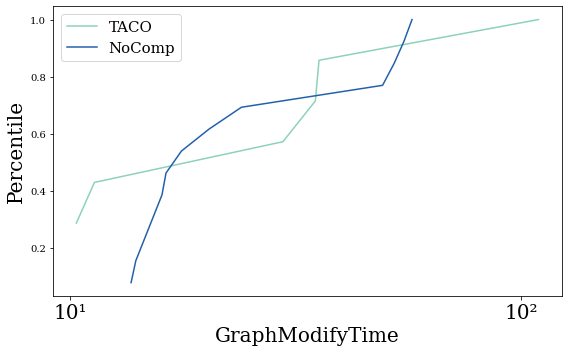

In [73]:
plot_percentile([freq_enron_taco_modify, freq_enron_nocomp_modify], 
                ["TACO", "NoComp"],
                xlabel="GraphModifyTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=2,
                x_tick_num=1
               )

In [74]:
freq_github_taco_modify = get_pdf_df(github_taco_modify_1k, 'GraphModifyTime', True)
freq_github_nocomp_modify = get_pdf_df(github_nocomp_modify_1k, 'GraphModifyTime', True)

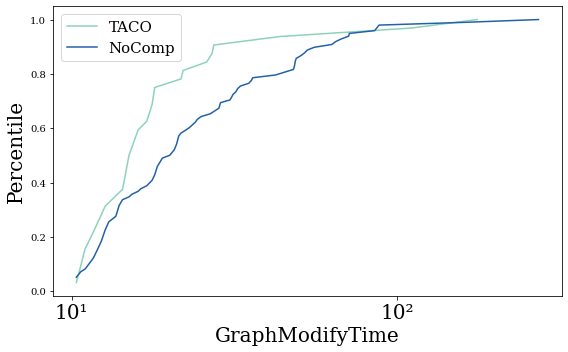

In [75]:
plot_percentile([freq_github_taco_modify, freq_github_nocomp_modify], 
                ["TACO", "NoComp"],
                xlabel="GraphModifyTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=2,
                x_tick_num=1
               )